# Required Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity

# Constants

In [ ]:

IMAGE_DIR = "/content/all_images/Flicker8k_Dataset"
CAPTION_FILE = "/content/all_captions/Flickr8k.lemma.token.txt"

# Set device for model operations

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Downloading and extracting the dataset

In [ ]:

!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

# Load and prepare dataset

In [ ]:
image_tokens = pd.read_csv(CAPTION_FILE, sep='\t', names=["img_id", "img_caption"])
image_tokens["img_id"] = image_tokens["img_id"].apply(lambda x: x[:-2])  # Clean image ids
image_tokens["img_caption"] = "<start> " + image_tokens["img_caption"].str.strip() + " <end>"
image_tokens['path'] = IMAGE_DIR + '/' + image_tokens['img_id']

# Installation of required packages

In [ ]:

!pip install -qq transformers torch datasets gdcm pydicom faiss-gpu pytesseract


# Load the CLIP model

In [ ]:

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


 # Process texts in a batch

In [ ]:
def get_text_embeddings_batch(texts):
    inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():  # Disable gradient calculation to save memory
        embeddings = model.get_text_features(**inputs)
    return embeddings.cpu()  # Move embeddings to CPU to free up GPU memory

# Function to process data in smaller batches to avoid overloading GPU memory
def process_in_batches(dataframe, text_column, batch_size=32):
    num_samples = len(dataframe)
    all_embeddings = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_texts = dataframe[text_column][start_idx:end_idx].tolist()
        batch_embeddings = get_text_embeddings_batch(batch_texts)
        all_embeddings.extend(batch_embeddings)

    return all_embeddings

In [ ]:
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


# Function to check file existence and load the image

In [ ]:
def load_image(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return None  # Return None if file doesn't exist
    image = Image.open(image_path).convert("RGB")
    # Apply transformations
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
def process_images_in_batches(dataframe, path_column, batch_size=10):
    num_samples = len(dataframe)
    all_embeddings = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_paths = dataframe[path_column][start_idx:end_idx].tolist()
        for path in batch_paths:
            if os.path.exists(path):
                embeddings = get_image_embeddings(path)
                all_embeddings.append(embeddings)
            else:
                # Append None or a predefined placeholder if the image does not exist
                all_embeddings.append(None)

    return all_embeddings

In [ ]:
def get_image_embeddings(image_path):
    try:
        image_tensor = load_image(image_path)
        if image_tensor is None:  # Skip processing if image wasn't loaded
            return None
        with torch.no_grad():
            embeddings = model.get_image_features(image_tensor.to(device))
        return embeddings.cpu()
    except Exception as e:
        print(f"Error processing file {image_path}: {e}")
        return None

In [ ]:
# Apply the function to get embeddings in batches
image_tokens['text_embeddings'] = process_in_batches(image_tokens, 'img_caption', batch_size=100)  #  batch_size based on GPU capacity

In [ ]:
# Apply batch processing to get image embeddings
image_tokens['img_embeddings'] = process_images_in_batches(image_tokens, 'path', batch_size=100)  #  batch_size based on GPU capacity

In [ ]:
def find_similar_images(query, data, top_n=5):
    # Get query embedding
    query_embedding = get_text_embeddings_batch(query).reshape(1, -1)

    # Define a helper function to compute cosine similarity safely
    def safe_cosine_similarity(embedding):
        if embedding is not None:
            return cosine_similarity(query_embedding, embedding.reshape(1, -1))[0][0]
        else:
            return -1  # Return a low similarity score if embedding is None

    # Apply safe cosine similarity calculation
    data['cos_sim'] = data['img_embeddings'].apply(safe_cosine_similarity)

    # Filter and sort data based on cosine similarity
    filtered_data = data.dropna(subset=['cos_sim'])  # Optional: drop entries with None embeddings
    top_images = filtered_data.sort_values(by='cos_sim', ascending=False).head(top_n)
    return top_images

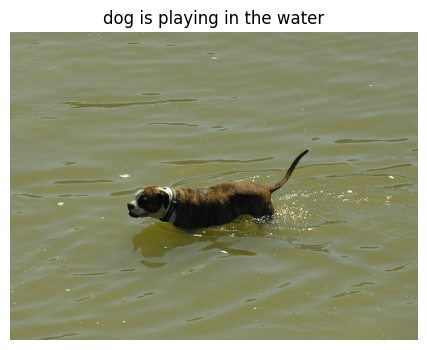

In [ ]:
# usage
query_caption = "dog is playing in the water"
top_images = find_similar_images(query_caption, image_tokens, top_n=1)

# Calculate the number of images
num_images = len(top_images)

# Displaying images
fig, axs = plt.subplots(1, num_images, figsize=(20, 4))  # Adjust subplot size dynamically based on the number of images

if num_images == 1:  # If there's only one image, axs is not a list but a single AxesSubplot object
    axs = [axs]

for ax, (idx, row) in zip(axs, top_images.iterrows()):
    img = Image.open(row['path'])
    ax.imshow(img)
    ax.set_title(query_caption)
    ax.axis('off')

plt.show()